In [1]:
from neo4j import GraphDatabase

url = "bolt://localhost:7687"
username = "neo4j"
password = "pleaseletmein"

# Connect to Neo4j
driver = GraphDatabase.driver(url, auth=(username, password))

In [2]:
import pandas as pd

def run_query(query, params={}):
    with driver.session() as session:
        result = session.run(query, params)
        return pd.DataFrame([r.values() for r in result], columns=result.keys())

In [3]:
# Create feature set
run_query("""
MATCH (s1:Stream)-[:SHARED_AUDIENCE]->(s2:Stream)
WITH s1, s2
ORDER BY s1.id,s2.id
WHERE rand() <= 0.9
MERGE (s1)-[:FEATURE_REL]->(s2);
""")

""


In [4]:
# Create test/train set
train_test_size = run_query("""
MATCH (s1)-[:SHARED_AUDIENCE]->(s2)
WHERE NOT EXISTS {(s1)-[:FEATURE_REL]->(s2)}
MERGE (s1)-[r:TEST_TRAIN]->(s2)
RETURN count(r) AS result;
""")

print(train_test_size)

   result
0   13288


In [5]:
# Create negative test/train pairs
run_query("""
MATCH (s1:Stream),(s2:Stream)
WHERE NOT EXISTS {(s1)-[:SHARED_AUDIENCE]-(s2)} AND s1 < s2
WITH s1,s2
LIMIT 13082
MERGE (s1)-[:NEGATIVE_TEST_TRAIN]->(s2);
""")

""


In [6]:
# Network distance
run_query("""
MATCH (s1)-[r:TEST_TRAIN|NEGATIVE_TEST_TRAIN]->(s2)
MATCH p = shortestPath((s1)-[:FEATURE_REL*]-(s2))
WITH r, length(p) AS networkDistance
SET r.networkDistance = networkDistance
""")

""


In [7]:
# Preferential attachment
run_query("""
MATCH (s1:Stream)-[r:TEST_TRAIN|NEGATIVE_TEST_TRAIN]->(s2)
WITH r, count{ (s1)-[:FEATURE_REL]-() } * 
        count{ (s2)-[:FEATURE_REL]-() } AS preferentialAttachment
SET r.preferentialAttachment = preferentialAttachment
""")


""


In [8]:
# Common neighbors
run_query("""
MATCH (s1:Stream)-[r:TEST_TRAIN|NEGATIVE_TEST_TRAIN]->(s2)
OPTIONAL MATCH (s1)-[:FEATURE_REL]-(neighbor)-[:FEATURE_REL]-(s2)
WITH r, count(distinct neighbor) AS commonNeighbor
SET r.commonNeighbor = commonNeighbor
""")

""


In [9]:
# Adamic Adar
run_query("""
MATCH (s1:Stream)-[r:TEST_TRAIN|NEGATIVE_TEST_TRAIN]->(s2:Stream)
OPTIONAL MATCH (s1)-[:FEATURE_REL]-(neighbor)-[:FEATURE_REL]-(s2)
WITH r, collect(distinct neighbor) AS commonNeighbors
UNWIND commonNeighbors AS cn
WITH r, count{ (cn)-[:FEATURE_REL]-() } AS neighborDegree
WITH r, sum(1 / log(neighborDegree)) AS adamicAdar
SET r.adamicAdar = adamicAdar;
""")

""


In [10]:
# Clustering coefficient of common neighbors
run_query("""
MATCH (s1:Stream)-[r:TEST_TRAIN|NEGATIVE_TEST_TRAIN]->(s2:Stream)
OPTIONAL MATCH (s1)-[:FEATURE_REL]-(neighbor)-[:FEATURE_REL]-(s2)
WITH r, collect(distinct neighbor) AS commonNeighbors, 
        count(distinct neighbor) AS commonNeighborCount
OPTIONAL MATCH (x)-[cr:FEATURE_REL]->(y)
WHERE x IN commonNeighbors AND y IN commonNeighbors
WITH r, commonNeighborCount, count(cr) AS commonNeighborRels
WITH r, CASE WHEN commonNeighborCount < 2 THEN 0 ELSE
   toFloat(commonNeighborRels) / (commonNeighborCount * 
                 (commonNeighborCount - 1) / 2) END as clusteringCoefficient
SET r.clusteringCoefficient = clusteringCoefficient
""")

""


In [11]:
# Fetch features
data = run_query("""
MATCH (s1)-[r:TEST_TRAIN|NEGATIVE_TEST_TRAIN]->(s2)
WITH r.networkDistance AS networkDistance,
     r.preferentialAttachment AS preferentialAttachment,
     r.commonNeighbor AS commonNeighbor,
     r.adamicAdar  AS adamicAdar,
     r.clusteringCoefficient  AS clusteringCoefficient,
     CASE WHEN r:TEST_TRAIN THEN 1 ELSE 0 END as output
RETURN networkDistance, preferentialAttachment, commonNeighbor,
       adamicAdar, clusteringCoefficient, output     
""")

In [12]:
data.head()

,networkDistance,preferentialAttachment,commonNeighbor,adamicAdar,clusteringCoefficient,output
0,2.0,120620,122,21.879895,0.664273,1
1,2.0,239020,165,32.764985,0.411752,1
2,2.0,28860,37,8.122382,0.683183,1
3,2.0,81400,36,7.033746,0.665079,1
4,2.0,25900,32,7.056529,0.729839,1


In [13]:
data.describe()

,networkDistance,preferentialAttachment,commonNeighbor,adamicAdar,clusteringCoefficient,output
count,26315.000000,2.637000e+04,26370.000000,24862.000000,26370.000000,26370.000000
mean,2.055938,3.453693e+04,41.233750,8.173823,0.712312,0.503906
std,0.232927,6.163047e+04,53.669347,10.326044,0.279080,0.499994
min,2.000000,0.000000e+00,0.000000,0.133793,0.000000,0.000000
25%,2.000000,5.103250e+03,6.000000,1.365832,0.666667,0.000000
50%,2.000000,1.478400e+04,21.000000,4.453779,0.804388,1.000000
75%,2.000000,4.056000e+04,55.000000,10.903394,0.882279,1.000000
max,4.000000,2.475610e+06,1037.000000,238.837813,1.000000,1.000000


In [14]:
data['networkDistance'].fillna(4, inplace=True)
data['adamicAdar'].fillna(8.097444, inplace=True)

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

X = data.drop("output", axis=1)
y = data["output"].to_list()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)

RandomForestClassifier()

In [16]:
from sklearn.metrics import classification_report

y_pred = rfc.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.92      0.92      2557
           1       0.92      0.91      0.92      2717

    accuracy                           0.92      5274
   macro avg       0.92      0.92      0.92      5274
weighted avg       0.92      0.92      0.92      5274



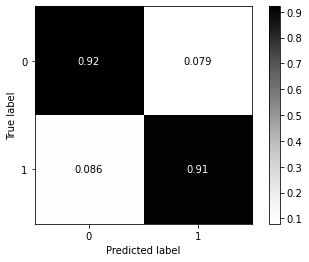

In [17]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(y_test, y_pred, normalize="true", cmap="Greys")

In [18]:
def feature_importance(columns, classifier):        
    features = list(zip(columns, classifier.feature_importances_))
    sorted_features = sorted(features, key = lambda x: x[1]*-1)
    
    keys = [value[0] for value in sorted_features]
    values = [value[1] for value in sorted_features]
    return pd.DataFrame(data={'feature': keys, 'value': values})

feature_importance(X.columns, rfc)

,feature,value
0,adamicAdar,0.313358
1,commonNeighbor,0.309560
2,preferentialAttachment,0.248628
3,clusteringCoefficient,0.125405
4,networkDistance,0.003049
